# ガウス尺度混合モデル (Gaussian scale mixture model)
## 神経活動の変動性による不確実性の表現

神経活動の変動性 (neural variability)




{cite:p}`Shimazaki2019-yx`, {cite:p}`Shimazaki2020-kx`,  {cite:p}`Orban2016-tm`, {cite:p}`Echeveste2020-sh`, 

自発活動が事前分布であるという説 {cite:p}`Fiser2010-kw`, {cite:p}`Berkes2011-it`.

## ガウス尺度混合モデル
**ガウス尺度混合 (Gaussian scale mixture; GSM) モデル**は確率的生成モデルの一種である{cite:p}`Wainwright1999-cl`．GSMモデルでは入力を次式で予測する：

$$
\text{入力}={z}\left(\sum \text{神経活動} \times \text{基底} \right) + \text{ノイズ}
$$

前節までのスパース符号化モデル等と同様に，入力が基底の線形和で表されるとしている．ただし，尺度(scale)パラメータ$z$が基底の線形和に乗じられている点が異なる．

```{note}
コードは{cite:p}`Orban2016-tm` <https://github.com/gergoorban/sampling_in_gsm>, および{cite:p}`Echeveste2020-sh` <https://bitbucket.org/RSE_1987/ssn_inference_numerical_experiments/src/master/>を参考に作成した．
```


### 事前分布
$\mathbf{x} \in \mathbb{R}^{N_x}$, $\mathbf{A} \in \mathbb{R}^{N_x\times N_y}$, $\mathbf{y} \in \mathbb{R}^{N_y}$, $\mathbf{z} \in \mathbb{R}$とする．

$$
p\left(\mathbf{x}\mid\mathbf{y}, z\right)=\mathcal{N}\left(z \mathbf{A} \mathbf{y}, \sigma_{\mathbf{x}}^{2} \mathbf{I}\right)
$$

事前分布を

$$
\begin{aligned}
p\left(\mathbf{y}\right)&=\mathcal{N}\left(\mathbf{0}, \mathbf{C}\right)\\
p\left(z\right)&=\Gamma (k, \vartheta)
\end{aligned}
$$

とする．$\Gamma(k, \vartheta)$はガンマ分布であり，$k$は形状(shape)パラメータ，$\vartheta$は尺度(scale)パラメータである．$p\left(\mathbf{y}\right)$は$\mathbf{y}$の事前分布であり，刺激がない場合の自発活動の分布を表していると仮定する．

### 重み行列$\mathbf{A}$の作成

In [1]:
using PyPlot, LinearAlgebra, Random, Distributions
using PyPlot: matplotlib
Random.seed!(0)
rc("axes.spines", top=false, right=false)

In [2]:
function gabor(x, y, θ, σ=1, λ=2, ψ=0)
    xθ = x * cos(θ) + y * sin(θ)
    yθ = -x * sin(θ) + y * cos(θ)
    return exp(-.5(xθ^2 + yθ^2)/σ^2) * cos(2π/λ * xθ + ψ)
end;

In [3]:
WH = 16   # width/height of input image
Nx = WH^2 # dimension of the observed variable x
Ny = 50  # dimension of the hidden variable y

A = zeros(Nx, Ny) # weight matrix
p = range(-3, 3, length=WH) # position
θg = (1:Ny) / Ny * π # theta for gabor
for i in 1:Ny
    gb = gabor.(p', p, θg[i])
    gb /= norm(gb) + 1e-8 # normalization
    A[:, i] = gb[:] # flatten and save
end;

重み行列$\mathbf{A}$の一部を描画してみよう．

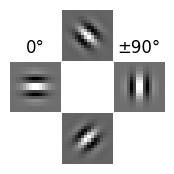

In [4]:
figure(figsize=(2,2))
plot_idx = [2,4,6,8]
weight_idx = [37,25,50,13]
titles = ["", "0°", "±90°", ""]
for i in 1:4
    subplot(3,3,plot_idx[i])
    title(titles[i])
    imshow(reshape(A[:, weight_idx[i]], WH, WH), cmap="gray")
    axis("off")
end
subplots_adjust(wspace=0.01, hspace=0.01)

In [5]:
# sampling from p(x|y, z)
Px_yz(y, z, A, σₓ) = MvNormal(vec(z*A*y), σₓ*I)

Px_yz (generic function with 1 method)

### 分散共分散行列$\mathbf{C}$の作成
$\mathbf{C}$は$y$の事前分布の分散共分散行列である．{cite:p}`Orban2016-tm`では自然画像を用いて作成しているが，ここでは簡単のため$\mathbf{A}$と同様に{cite:p}`Echeveste2020-sh`に従って作成する．前項で作成した通り，$\mathbf{A}$の各基底には周期性があるため，類似した基底を持つニューロン同士は類似した出力をすると考えられる．Echevesteらは$\theta\in[-\pi/2, \pi/2)$の範囲においてFourier基底を複数作成し，そのグラム行列(Gram matrix)を係数倍したものを$\mathbf{C}$と設定している．ここではガウス過程(Gaussian process)モデルとの類似性から，周期カーネル(periodic kernel) 

$$
K(\theta, \theta')=\exp\left[\phi_1 \cos \left(\dfrac{|\theta-\theta'|}{\phi_2}\right)\right]
$$

を用いる．ここでは$|\theta-\theta'|=m\pi\ (m=0,1,\ldots)$の際に類似度が最大になればよいので，$\phi_2=0.5$とする．これが正定値行列になるように単位行列の係数倍$\epsilon\mathbf{I}$を加算し，スケーリングした上で，`Symmetric(C)`や`Matrix(Hermitian(C)))`により実対象行列としたものを$\mathbf{C}$とする．$\mathbf{C}$を正定値行列にする理由はJuliaの`MvNormal`がCholesky分解を用いて多変量正規分布の乱数を生成するためである． 事前に`cholesky(C)`が実行できるか確認するのもよい．

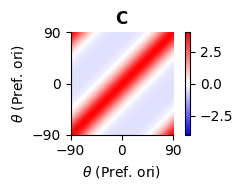

In [6]:
K(x₁, x₂, ψ₁, ψ₂) = exp(ψ₁ * cos(abs(x₁-x₂) / ψ₂)) # periodic kernel
C = K.(θg', θg, 2.0, 0.5) # create covariance matrix
C += 0.1 * I # regularization to make C positive definite
C_min, C_max = minimum(C), maximum(C)
C_range = [-0.5, 4.0] # target min-max of C
C = C_range[1] .+ (C_range[2]-C_range[1]) * (C .- C_min) / (C_max - C_min);
C = Symmetric(C); # make symmetric matrix using upper triangular matrix

figure(figsize=(3,2))
title(L"$\mathbf{C}$")
ims = imshow(C, origin="lower", cmap="bwr", vmin=-4, vmax=4, extent=(-90, 90, -90, 90))
xticks([-90,0,90]); yticks([-90,0,90]); 
xlabel(L"$\theta$ (Pref. ori)"); ylabel(L"$\theta$ (Pref. ori)")
colorbar(ims);
tight_layout()

ここでPref. oriは最適方位 (preferred orientation)を意味する．

### 事後分布の計算
事後分布は$z$と$\mathbf{y}$のそれぞれについて次のように求められる．


$$
\begin{aligned}
p(z \mid \mathbf{x}) &\propto p(z) \mathcal{N}\left(0, z^{2} \mathbf{A C A}^{\top}+\sigma_{x}^{2} \mathbf{I}\right)\\
p(\mathbf{y} \mid z, \mathbf{x})& = \mathcal{N}\left(\mu(z, \mathbf{x}), \Sigma(z)\right)
\end{aligned}
$$

ただし，

$$
\begin{aligned}
\Sigma(z)&=\left(\mathbf{C}^{-1}+\frac{z^{2}}{\sigma_{x}^{2}} \mathbf{A}^{\top} \mathbf{A}\right)^{-1}\\
\mu(z, \mathbf{x})&=\frac{z}{\sigma_{x}^{2}} \Sigma(z) \mathbf{A}^{\top} \mathbf{x}
\end{aligned}
$$

である．

最終的な予測において$z$の事後分布は必要でないため，$p(\mathbf{y} \mid z, \mathbf{x})$から$z$を消去することを考えよう．厳密に行う場合，次式のように周辺化(marginalization)により，$z$を（積分）消去する必要がある．

$$
p(\mathbf{y} \mid \mathbf{x}) = \int dz\ p(z\mid \mathbf{x})\cdot p(\mathbf{y} \mid z, \mathbf{x})
$$

周辺化においては，まず$z$のMAP推定（最大事後確率推定）値 $z_{\mathrm{MAP}}$を求める．

$$
z_{\mathrm{MAP}} = \underset{z}{\operatorname{argmax}} p(z\mid \mathbf{x})
$$

次に$z_{\mathrm{MAP}}$の周辺で$p(z\mid \mathbf{x})$を積分し，積分値が一定の閾値を超える$z$の範囲を求め，この範囲で$z$を積分消去してやればよい．しかし，$z$は単一のスカラー値であり，この手法で推定するのは煩雑であるために近似手法が{cite:p}`Echeveste2017-wu`において提案されている．Echevesteらは第一の近似として，$z$の分布を$z_{\mathrm{MAP}}$でのデルタ関数に置き換える，すなわち，$p(z\mid \mathbf{x})\simeq \delta (z-z_{\mathrm{MAP}})$とすることを提案している．この場合，$z$は定数とみなせ，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z_{\mathrm{MAP}})$となる．第二の近似として，$z_{\mathrm{MAP}}$を真のコントラスト$z^*$で置き換えることが提案されている．GSMへの入力$\mathbf{x}$は元の画像を$\mathbf{\tilde x}$とすると，$\mathbf{x}=z^* \mathbf{\tilde x}$としてスケーリングされる．この入力の前処理の際に用いる$z^*$を用いてしまおうということである．この場合，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z^*)$となる．しかし，入力を任意の画像とする場合，$z^*$は未知である．簡便さと精度のバランスを取り，ここでは第一の近似，$z=z_{\mathrm{MAP}}$とする手法を用いることにする．

In [7]:
# log pdf of p(z)
log_Pz(z, k, θ) = logpdf.(Gamma(k, θ), z)

# pdf of p(z|x)
function Pz_x(z_range, x, ACAᵀ, σₓ², k, θ)
    n_contrasts = length(z_range)
    log_p = zeros(n_contrasts)
    μxz = zeros(size(x))
    dz = z_range[2] - z_range[1]
    for i in 1:n_contrasts
        Cxz = z_range[i]^2 * ACAᵀ + σₓ² * I
        log_p[i] = log_Pz(z_range[i], k, θ) + logpdf(MvNormal(μxz, Symmetric(Cxz)), x)
    end
    p = exp.(log_p .- maximum(log_p)) # for numerical stability
    p /= sum(p) * dz
    return p
end;

In [8]:
# mean and covariance matrix of p(y|x, z)
function post_moments(x, z, σₓ², A, AᵀA, C⁻¹)
    Σz = inv(C⁻¹ + (z^2 / σₓ²) * AᵀA)
    μzx = (z/σₓ²) * Σz * A' * x
    return μzx, Σz
end;

### シミュレーション

In [9]:
AᵀA = A' * A
ACAᵀ = A * C * A'

σₓ = 1.0 # Noise of the x process
σₓ² = σₓ^2
k, θ = 2.0, 2.0 # Parameter of the gamma dist. for z (Shape, Scale)

C⁻¹ = inv(C); # We will need the inverse of C

入力データの作成

In [10]:
Z = [0.0, 0.25, 0.5, 1.0, 2.0] # set true contrasts z^*
n_samples = size(Z)[1]
y = rand(MvNormal(zeros(Ny), Symmetric(C)), 1) # sampling from P(y)=N(0, C)
X = hcat([rand(Px_yz(y, z, A, σₓ)) for z in Z]...)';

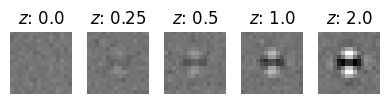

In [11]:
x_min, x_max = minimum(X), maximum(X)

figure(figsize=(4,2))
for s in 1:n_samples
    subplot(1, n_samples, s)
    title(L"$z$: "*string(Z[s]))
    imshow(reshape(X[s, :], WH, WH), vmin=x_min, vmax=x_max, cmap="gray")
    axis("off")
end
tight_layout()

事後分布の計算をする．

In [12]:
μ_post = zeros(n_samples, Ny)
σ_post = zeros(n_samples, Ny)
Σ_post = zeros(n_samples, Ny, Ny)

z_range = range(0, 5.0, length=100) # range of z for MAP estimation
Z_MAP = zeros(n_samples) 

for s in 1:n_samples
    p_z = Pz_x(z_range, X[s, :], ACAᵀ, σₓ², k, θ)
    Z_MAP[s] = z_range[argmax(p_z)] # MAP estimated z
    μ_post[s, :], Σ_post[s, :, :] = post_moments(X[s, :], Z_MAP[s], σₓ², A, AᵀA, C⁻¹)
    σ_post[s, :] = sqrt.(diag(Σ_post[s, :, :]))
end

### 結果

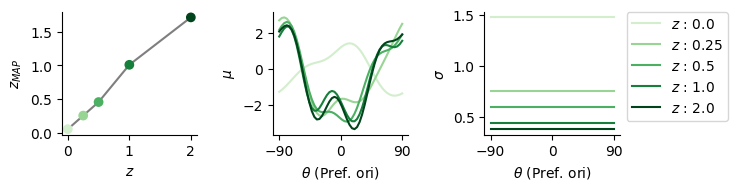

In [13]:
θs = range(-90, 90, length=Ny)
cm = get_cmap(:Greens) # get color map
cms = cm.((1:n_samples)/n_samples) # color list

fig, ax = subplots(1, 3, figsize=(7.5, 2))
ax[1].scatter(Z, Z_MAP, c=cms)
ax[1].plot(Z, Z_MAP, color="tab:gray", zorder=0)
ax[1].set_xlabel(L"$z$"); ax[1].set_ylabel(L"$z_{MAP}$"); 
for s in 1:n_samples
    ax[2].plot(θs, μ_post[s, :], color=cms[s])
    ax[3].plot(θs, σ_post[s, :], color=cms[s], label=L"$z$ : "*string(Z[s]))
end
ax[2].set_ylabel(L"$\mu$"); ax[3].set_ylabel(L"$\sigma$")
for i in 2:3
    ax[i].set_xticks([-90,0,90])
    ax[i].set_xlabel(L"$\theta$ (Pref. ori)")
end
ax[3].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

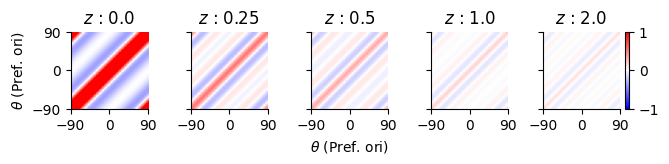

In [14]:
fig, ax = subplots(1, n_samples, figsize=(7.5, 1), sharex="all", sharey="all")
for s in 1:n_samples
    ax[s].set_title(L"$z$ : "*string(Z[s]))
    ims = ax[s].imshow(Σ_post[s, :, :], origin="lower", cmap="bwr", extent=(-90, 90, -90, 90), vmin=-1, vmax=1)
    ax[s].set_xticks([-90,0,90]); ax[s].set_yticks([-90,0,90]);
    if s == 1
        ax[s].set_ylabel(L"$\theta$ (Pref. ori)")
    elseif s == ceil(Int, n_samples/2) 
        ax[s].set_xlabel(L"$\theta$ (Pref. ori)"); 
    end
end
fig.colorbar(ims, ax=ax[n_samples]);

### 出力のサンプリング

In [15]:
membrane_potential(y, α=2.4, β=1.9, γ=0.6) = α * max(0, y+β)^γ

function low_pass_filter(x, η=0.2)
    x_filtered = zeros(size(x)) # num. of neuron, time steps
    x_filtered[:, 1] = x[:, 1]
    for t in 1:size(x)[2]-1
        x_filtered[:, t+1] = (1-η) * x_filtered[:, t] + η * x[:, t+1]
    end
    return x_filtered
end;

事後分布から応答をサンプリングする．

In [16]:
nt = 100
u = zeros(n_samples, Ny, nt)
for s in 1:n_samples
    μ = μ_post[s, :]
    Σ = Σ_post[s, :, :]
    sample = rand(MvNormal(μ, Symmetric(Σ)), nt)
    u[s, :, :] = low_pass_filter(membrane_potential.(sample))
end

In [17]:
# modified from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
function confidence_ellipse(x, y, ax, n_std=3, alpha=1, facecolor="none", edgecolor="tab:gray")
    pearson = cor(x,y)
    rx, ry = sqrt(1 + pearson), sqrt(1 - pearson)
    ellipse = matplotlib.patches.Ellipse((0, 0), width=2*rx, height=2*ry, alpha=alpha, 
        fc=facecolor, ec=edgecolor, lw=2, zorder=0)
    scales = [std(x), std(y)] * n_std
    means = [mean(x), mean(y)]
    transf = matplotlib.transforms.Affine2D().rotate_deg(45).scale(scales...).translate(means...)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
end;

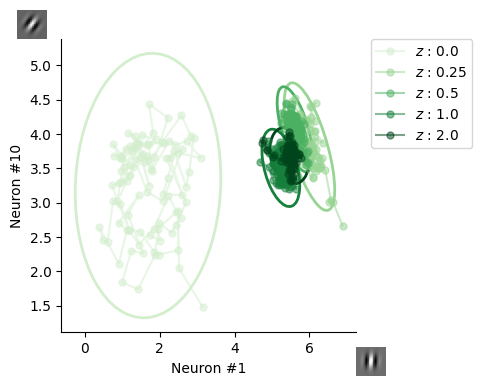

In [18]:
fig, ax = subplots(figsize=(5, 4))
unit_idx = [1, 10]
for s in 1:n_samples
    u₁, u₂ = u[s, unit_idx[1], :], u[s, unit_idx[2], :]
    ax.plot(u₁, u₂, marker="o", markersize=5, alpha=0.5, color=cms[s], label=L"$z$ : "*string(Z[s]))
    confidence_ellipse(u₁, u₂, ax, 3, 1, "none", cms[s])
end
ax.set_xlabel("Neuron #"*string(unit_idx[1])); ax.set_ylabel("Neuron #"*string(unit_idx[2]))
axins = [ax.inset_axes([1, -0.15,0.1,0.1]), ax.inset_axes([-0.15,1,0.1,0.1])]
for i in 1:2
    axins[i].imshow(reshape(A[:,unit_idx[i]], WH, WH), cmap="gray")
    axins[i].axis("off")
end
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

## 神経活動のサンプリング仮説
Neural sampling

bayesian brain without probability {cite:p}`Sanborn2016-en`


neural sampling

In [19]:
using ForwardDiff

In [20]:
function leapfrog(grad::Function, θ::Vector{Float64}, p::Vector{Float64}, ϵ::Float64, L::Int)
    for l in 1:L
        p += 0.5 * ϵ * grad(θ)
        θ += ϵ * p
        p += 0.5 * ϵ * grad(θ)
    end
    return θ, p
end;

In [21]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function HMC(log_p::Function, θ_init::Vector{Float64}, num_iter::Int, L::Int, ϵ::Float64)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        p = randn(d) # get momentum        
        H = -log_p(θ) + 0.5 * p' * p        # initial Hamiltonian
        θ_, p_ = leapfrog(grad, θ, p, ϵ, L) # update
        H_ = -log_p(θ_) + 0.5 * p_' * p_    # final Hamiltonian
        
        if min(1, exp(H - H_)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

zも推定すべきであるが，$z$が非負値であることからここでは省略する．



In [22]:
sigmoid(z) = 1 / (1 + exp(-z))
#dsigmoid(z) = -2 * exp(z) / (exp(z) - 1)^2 #2 * (1-sigmoid(z))*sigmoid(z)
dsigmoid(z) = (1-sigmoid(z)) * sigmoid(z)

dsigmoid (generic function with 1 method)

In [144]:
function log_joint(zy, x, A, μy, σₓ, k, θ)
    #z = 2*sigmoid(zy[1])
    z = abs(zy[1])
    #z = exp(zy[1])
    y = zy[2:end]
    μx = z*A*y
    tmp = logpdf(MvNormal(μx[:, 1], σₓ*I), x)
    tmp += logpdf(MvNormal(μy, Symmetric(C)), y)[1]
    tmp += logpdf(Gamma(k, θ), z) # + log(0.5)
    return tmp
end

log_joint (generic function with 1 method)

In [145]:
num_iter = 300
L = 20
ϵ = 0.02; # step size

In [146]:
param_posteriors = zeros(n_samples, Ny+1, num_iter)
for s in 1:n_samples
    params = (X[s, :], A, zeros(Ny), σₓ, k, θ);
    num_accepted = 0
    while num_accepted < num_iter/3
        #y_init = [log(Z[s]+1e-8); rand(MvNormal(zeros(Ny), Symmetric(C)), 1)[:]]
        y_init = [rand(); rand(MvNormal(zeros(Ny), Symmetric(C)), 1)[:]]
        ulp(y) = log_joint(y, params...) # unnormalized log-posterior
        param_posterior, num_accepted = HMC(ulp, y_init, num_iter, L, ϵ)#s[s])
        if num_accepted > num_iter/3
            param_posteriors[s, :, :] = param_posterior
        end
        println("[$s/$n_samples] num_accepted: $num_accepted")
    end
end

[1/5] num_accepted: 291
[2/5] num_accepted: 245
[3/5] num_accepted: 297
[4/5] num_accepted: 292
[5/5] num_accepted: 289


In [147]:
#2*sigmoid.(mean(param_posteriors[:, 1, :], dims=2))
(mean(abs.(param_posteriors[:, 1, 200:end]), dims=2))
#exp.(mean(param_posteriors[:, 1, :], dims=2))

5×1 Matrix{Float64}:
 0.1867307225438857
 0.21344544296760032
 0.5904991483173665
 1.7709206400288158
 2.440127642419621

In [128]:
size(param_posteriors)

(5, 51, 300)

In [148]:
uhmc = zeros(n_samples, Ny, num_iter)
for s in 1:n_samples
    uhmc[s, :, :] = low_pass_filter(membrane_potential.(param_posteriors[s, 2:end, :]))
end;

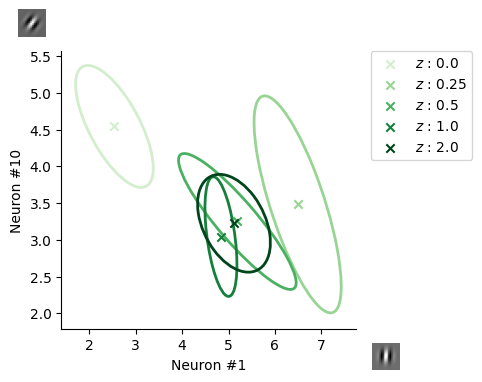

In [149]:
fig, ax = subplots(figsize=(5, 4))
for s in 1:n_samples
    u₁, u₂ = uhmc[s, unit_idx[1]+1, 250:end], uhmc[s, unit_idx[2]+1, 250:end]
    #ax.plot(u₁, u₂, marker="o", markersize=5, alpha=0.5, color=cms[s], label=L"$z$ : "*string(Z[s]))
    ax.scatter(mean(u₁), mean(u₂), color=cms[s], marker="x", label=L"$z$ : "*string(Z[s]))
    confidence_ellipse(u₁, u₂, ax, 3, 1, "none", cms[s])
end
ax.set_xlabel("Neuron #"*string(unit_idx[1])); ax.set_ylabel("Neuron #"*string(unit_idx[2]))
axins = [ax.inset_axes([1.05, -0.15,0.1,0.1]), ax.inset_axes([-0.15,1.05,0.1,0.1])]
for i in 1:2
    axins[i].imshow(reshape(A[:,unit_idx[i]], WH, WH), cmap="gray")
    axins[i].axis("off")
end
#ax.set_xlim(0, 4)
#ax.set_ylim(3, 6)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

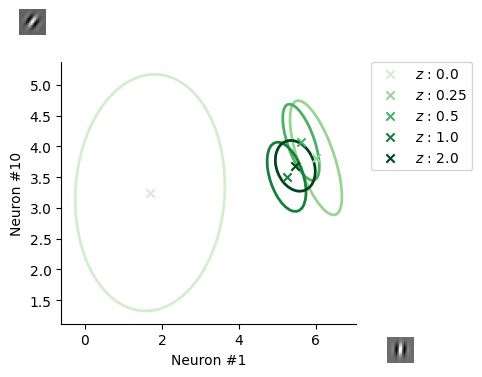

In [59]:
fig, ax = subplots(figsize=(5, 4))
for s in 1:n_samples
    u₁, u₂ = u[s, unit_idx[1], :], u[s, unit_idx[2], :]
    #ax.plot(u₁, u₂, marker="o", markersize=5, alpha=0.5, color=cms[s], label=L"$z$ : "*string(Z[s]))
    ax.scatter(mean(u₁), mean(u₂), color=cms[s], marker="x", label=L"$z$ : "*string(Z[s]))
    confidence_ellipse(u₁, u₂, ax, 3, 1, "none", cms[s])
end
ax.set_xlabel("Neuron #"*string(unit_idx[1])); ax.set_ylabel("Neuron #"*string(unit_idx[2]))
axins = [ax.inset_axes([1.1, -0.15,0.1,0.1]), ax.inset_axes([-0.15,1.1,0.1,0.1])]
for i in 1:2
    axins[i].imshow(reshape(A[:,unit_idx[i]], WH, WH), cmap="gray")
    axins[i].axis("off")
end
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
#ax.set_xlim(0, 4)
#ax.set_ylim(3, 6)
tight_layout()

より改善する場合はNUTSなどの優れたsamplerを使うことも考えられる．ただし，biologicalな実装は困難となる．`AdvancedHMC.jl`等を使うとよい．

## 参考文献
```{bibliography}
:filter: docname in docnames
```